In [40]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.utils import resample

In [41]:
DATA_PATH = os.path.join(os.getcwd(), '..', '1.CIMB Hackathon')
os.listdir(DATA_PATH)

['.Rhistory',
 'preprocessing.ipynb',
 'data_exploration.ipynb',
 '.DS_Store',
 '1. DEMO_BANK_INFO.csv',
 'SUBMISSION.csv',
 'CIMB 3D Conquest Brief 2018 29112018.pptx',
 '3. AGGREGATED_TELCO_TRANSACTIONS.csv',
 '~$Data Dictionary.xlsx',
 '4. MOBILE_OS.csv',
 '.ipynb_checkpoints',
 'Data Dictionary.xlsx',
 '5. RAW_TELCO_TRANSACTIONS.csv',
 '2. BANK_TELCO_ID_MATCH.csv',
 'VALIDATION_SET.csv']

In [42]:
demo_bank_df = pd.read_csv(os.path.join(DATA_PATH, '1. DEMO_BANK_INFO.csv'))
demo_bank_df.head()

,BANK_ID,AGE,MARITAL_STATUS,POSTAL_CD,GENDER,EDUCATION,STATE,OCCUPATION,OCC_DESC,CUST_SEGMENT,...,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,INS_NON_LIFE_CNT,INS_CNT,loan_application_date,DELQ_FLG
0,13398,42,Single,48020.0,Male,No Formal Education / Unknown,Selangor Darul Ehsan,"Associate Professionals, Administrative/Specia...",MANAGER OR SUPERVISOR,MASS,...,2,0,0,0,0,0,0,0,31-Dec-17,N
1,16152,37,Married,73430.0,Male,No Formal Education / Unknown,Negeri Sembilan Darul Khusus,Associate Professionals/Technician/Asst/Superv...,OTHERS,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
2,18560,34,Single,70450.0,Male,No Formal Education / Unknown,Negeri Sembilan Darul Khusus,"Clerical Support Workers, Office - General Off...",NON-EXECUTIVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
3,18568,34,Married,47130.0,Male,College/ University,Selangor Darul Ehsan,Associate Professionals/Technician/Asst/Superv...,EXECUTIVE AND ABOVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
4,26717,26,Single,5150.0,Female,NaN,Kedah Darul Aman,"Professionals, Administration/Policy Analyst/M...",EXECUTIVE AND ABOVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N


In [43]:
def preprocessing_1(dataframe, save=False):
    '''
    Function that does the preprocessing according to #1 refer to readme
    '''
    dataframe.drop(columns=['POSTAL_CD', 'OCCUPATION',
                            'INS_CNT', 'CA_AVG_BAL', 'INS_NON_LIFE_CNT'], inplace=True)
    dataframe.update(dataframe[['SA_AVG_BAL', 'CA_CNT', 'SA_CNT']].fillna(0))
    dataframe.update(dataframe['EDUCATION'].fillna(
        'No Formal Education / Unknown'))
    dataframe['DELQ_FLG'] = np.where(dataframe['DELQ_FLG']=='Y', 1, 0)
    
    # Age
    dataframe['AGE'] = pd.cut(
        dataframe.AGE, [21, 28, 32, 39, 59], include_lowest=True, labels=[0, 1, 2, 3])

    # Marital Status
    dataframe['MARITAL_STATUS'][(dataframe['MARITAL_STATUS'] == 'Not Applicable / Blank') | (
        dataframe['MARITAL_STATUS'] == 'Divorced') | (dataframe['MARITAL_STATUS'] == 'Widow')] = 'Others'

    # State
    dataframe['STATE'][dataframe['STATE'].isin(
        ['WP - Kuala Lumpur', 'STATE_INFO_NOT_PROVIDED'])] = 'HH'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['WP - Labuan', 'Pulau Pinang', 'Sarawak', 'Selangor Darul Ehsan', 'WP - Putrajaya','Melaka'])] = 'H'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Negeri Sembilan Darul Khusus', 'Pahang Darul Makmur', 'Johor Darul Takzim', 'Terengganu Darul Iman', 'Perak Darul Ridzuan'])] = 'M'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Sabah', 'Perlis Indra Kayangan', 'Kedah Darul Aman'])] = 'L'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Kelantan Darul Naim'])] = 'LL'

    # Education
    dataframe['EDUCATION'][dataframe['EDUCATION'].isin(
        ['Primary', 'Secondary', 'No Formal Education / Unknown'])] = 'LE'
    dataframe['EDUCATION'][~dataframe['EDUCATION'].isin(['LE'])] = 'HE'

    # OCC DESC
    dataframe['OCC_DESC'][dataframe['OCC_DESC'].isin(
        ['MANAGER OR SUPERVISOR', 'EXECUTIVE AND ABOVE'])] = 'EXEC2MANAGER'
    dataframe['OCC_DESC'][dataframe['OCC_DESC'].isin(
        ['HOUSEWIFE', 'SELF EMPLOYED', 'STUDENT', 'RETIRED'])] = 'OTHERS'

    # Salary Avg Bal
    scaler = preprocessing.MinMaxScaler()
    dataframe['SA_AVG_BAL'] = pd.DataFrame(
        scaler.fit_transform(dataframe[['SA_AVG_BAL']]))

    # loan application dates
    dataframe['loan_application_date_DOW'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).dayofweek
    dataframe['loan_application_date_month'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).month
    dataframe['loan_application_date_week'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).week
    dataframe.drop(columns=['loan_application_date'], inplace=True)

    # One Hot encoding
    dataframe = pd.get_dummies(dataframe, columns=['AGE', 'MARITAL_STATUS', 'GENDER', 'EDUCATION', 'STATE', 'OCC_DESC',
                                                   'CUST_SEGMENT', 'loan_application_date_DOW', 'loan_application_date_month', 'loan_application_date_week'])

    if save:
        SAVE_PATH = os.path.join(os.getcwd(), '..', 'data')
        dataframe.to_csv(os.path.join(SAVE_PATH, 'preprocessed_1.csv'))
    return dataframe


In [44]:
def preprocessing_2(datapath, save=False):
    '''
    Function that does the preprocessing according to #2 refer to readme
    '''
    temp_df1 = pd.read_csv(os.path.join(datapath, '2. BANK_TELCO_ID_MATCH.csv'))
    temp_df2 = pd.read_csv(os.path.join(datapath, '3. AGGREGATED_TELCO_TRANSACTIONS.csv'))
    temp_df3 = pd.read_csv(os.path.join(datapath, '4. MOBILE_OS.csv'))


    # Avg postpaid and prepaid amt
    scaler = preprocessing.MinMaxScaler()
    temp_df2['AVG_POSTPAID_AMT'] = pd.DataFrame(scaler.fit_transform(temp_df2[['AVG_POSTPAID_AMT']]))
    temp_df2['AVG_PREPAID_AMT'] = pd.DataFrame(scaler.fit_transform(temp_df2[['AVG_PREPAID_AMT']]))
    temp_df2 = temp_df2.filter(['TELCO_ID', 'AVG_POSTPAID_AMT', 'AVG_POSTPAID_CNT', 'AVG_PREPAID_AMT', 'AVG_PREPAID_CNT'])


    # OS
    android = ['samsung', 'OPPO', 'HUAWEI', 'SONY', 'XIAOMI', 'LENOVO', 'ASUS', 'VIVO', 'ANDROID', 'Android_OS8', 'Android_OS7', 'Android_OS6', 'Android_OS5', 'Android_OS4_1']
    ios = ['IPAD_TAG', 'IPHONE_TAG', 'IPHONE_IOS8', 'IPHONE_IOS9', 'IPHONE_IOS10', 'IPHONE_IOS11']

    temp_df3['Android'] = temp_df3.loc[:, android].sum(axis=1)
    temp_df3['IOS'] = temp_df3.loc[:, ios].sum(axis=1)

    temp_df3['Android'][temp_df3['Android'] > 0] = 1
    temp_df3['IOS'][temp_df3['IOS'] > 0] = 1

    temp_df3 = temp_df3.filter(['BANK_ID', 'Android', 'IOS'])


    # Clean telco data
    cleaned_telco_df = temp_df1.merge(temp_df2, on='TELCO_ID', how='left').merge(temp_df3, on='BANK_ID', how='left')
    cleaned_telco_df.update(cleaned_telco_df[['AVG_POSTPAID_AMT', 'AVG_POSTPAID_CNT', 'AVG_PREPAID_AMT', 'AVG_PREPAID_CNT']].fillna(0))
    
    return cleaned_telco_df

In [45]:
def preprocessing_3(cleaned_bank_df, cleaned_telco_df, save=False):
    '''
    Function that does the preprocessing according to #3 refer to readme
    '''
    full_df = cleaned_bank_df.merge(cleaned_telco_df, on='BANK_ID', how='left')
    full_df.drop(columns=['BANK_ID', 'TELCO_ID'], inplace=True)
    full_df = full_df.dropna()
    
    return full_df

In [46]:
# Clean bank data
cleaned_bank_df = preprocessing_1(demo_bank_df)
cleaned_bank_df.head()

/Users/erictanyz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/erictanyz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/erictanyz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/erictanyz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value i

,BANK_ID,DEPENDENT_CNT,SA_AVG_BAL,CA_CNT,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,...,loan_application_date_week_43,loan_application_date_week_44,loan_application_date_week_45,loan_application_date_week_46,loan_application_date_week_47,loan_application_date_week_48,loan_application_date_week_49,loan_application_date_week_50,loan_application_date_week_51,loan_application_date_week_52
0,13398,0,0.003354,0.0,1.0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,16152,0,0.006562,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,18560,0,0.000000,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,18568,3,0.000000,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,26717,0,0.000000,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
# Clean telco data
cleaned_telco_df = preprocessing_2(DATA_PATH)
cleaned_telco_df.head()

,BANK_ID,TELCO_ID,AVG_POSTPAID_AMT,AVG_POSTPAID_CNT,AVG_PREPAID_AMT,AVG_PREPAID_CNT,Android,IOS
0,12140,C-42552,0.185614,2.500000,0.141509,3.541667,0.0,1.0
1,17875,C-50147,0.000000,0.000000,0.000000,0.000000,1.0,1.0
2,12935,C-43558,0.077290,1.041667,0.163915,10.000000,1.0,0.0
3,18777,C-51391,0.000000,0.000000,0.000000,0.000000,1.0,0.0
4,17083,C-49078,0.000000,0.000000,0.000000,0.000000,0.0,1.0


In [48]:
full_df = preprocessing_3(cleaned_bank_df, cleaned_telco_df)

full_df.head()

,DEPENDENT_CNT,SA_AVG_BAL,CA_CNT,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,...,loan_application_date_week_49,loan_application_date_week_50,loan_application_date_week_51,loan_application_date_week_52,AVG_POSTPAID_AMT,AVG_POSTPAID_CNT,AVG_PREPAID_AMT,AVG_PREPAID_CNT,Android,IOS
0,0,0.003354,0.0,1.0,2,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.082547,1.458333,1.0,0.0
1,0,0.006562,0.0,1.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,1.0,0.0
2,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,1.0,0.0
4,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,1.0,0.0
5,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,0.0,1.0


In [49]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14569 entries, 0 to 17480
Data columns (total 82 columns):
DEPENDENT_CNT                     14569 non-null int64
SA_AVG_BAL                        14569 non-null float64
CA_CNT                            14569 non-null float64
SA_CNT                            14569 non-null float64
CC_CNT                            14569 non-null int64
HP_CNT                            14569 non-null int64
TL_CNT                            14569 non-null int64
TLi_CNT                           14569 non-null int64
INS_CREDIT_LIFE_CNT               14569 non-null int64
INS_LIFE_CNT                      14569 non-null int64
DELQ_FLG                          14569 non-null int64
AGE_0                             14569 non-null uint8
AGE_1                             14569 non-null uint8
AGE_2                             14569 non-null uint8
AGE_3                             14569 non-null uint8
MARITAL_STATUS_Married            14569 non-null uint8
MARIT

In [61]:
downsampled_df = full_df.drop(columns = list(full_df.filter(regex='loan_application_date_DOW_*')))
downsampled_df.drop(columns = list(downsampled_df.filter(regex='loan_application_date_week_*')), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(downsampled_df.drop(columns = ['DELQ_FLG']), downsampled_df['DELQ_FLG'], test_size = 0.1, random_state = 42)

In [62]:
X_test.shape[0]

1457

In [58]:
_, temp = np.unique(np.array(y_train == 1), return_counts=True)
temp[-1]
#X_train = resample(X_train, replace = False, n_samples = temp[-1])


649

In [12]:
clf = RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train, y_train)
rf_y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, rf_y_pred))

Accuracy: 0.7160940325497287


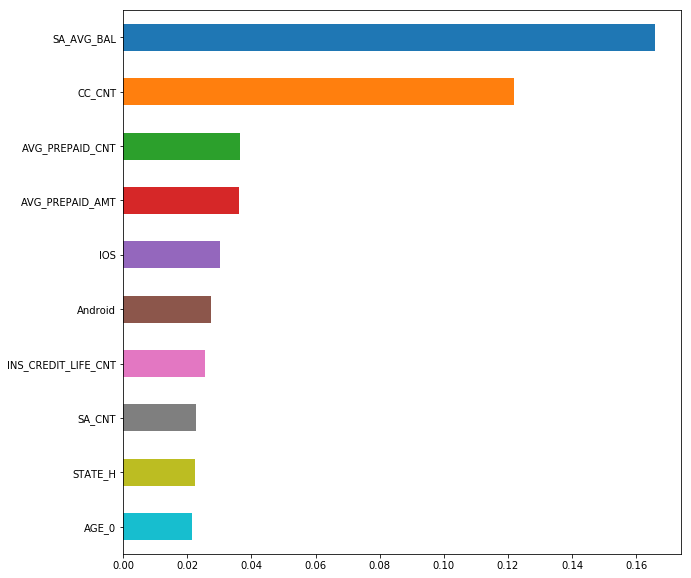

In [13]:
pd.Series(clf.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh', figsize = (10, 10)).invert_yaxis();

In [14]:
print(metrics.confusion_matrix(y_test, rf_y_pred))

[[164  91]
 [ 66 232]]


In [15]:
print(metrics.classification_report(y_test, rf_y_pred))

             precision    recall  f1-score   support

          0       0.71      0.64      0.68       255
          1       0.72      0.78      0.75       298

avg / total       0.72      0.72      0.71       553



In [16]:
metrics.roc_auc_score(y_test, rf_y_pred)

0.7108303724174233